# Loading Dataset from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"troygloyn","key":"c2ed0d60e59a0a8a6b4343b29b656c3a"}'}

In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohammadhossein77/brain-tumors-dataset --unzip --force

 99% 220M/221M [00:12<00:00, 27.3MB/s]
100% 221M/221M [00:12<00:00, 18.5MB/s]


# Packages

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Retrieving Dataset

In [ ]:
from PIL import Image
import os

# Path to the folder containing the images
image_files_paths = ['/content/Data/Normal',
                      '/content/Data/Tumor/glioma_tumor',
                      '/content/Data/Tumor/meningioma_tumor',
                      '/content/Data/Tumor/pituitary_tumor']


# Initialize empty lists to store the image data and file names
image_data = []
file_names = []

# Loop through each folder path
for folder_path in image_files_paths:
    # List all the image file names in the folder
    image_files = os.listdir(folder_path)

    # Loop through each image file
    for file_name in image_files:
        # Read the image using PIL
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)

        # Convert the image to a format compatible with DataFrame (e.g., numpy array)
        image_data.append(np.array(image))
        file_names.append(file_name)

# Now, image_data contains the processed image data and file_names contains the corresponding file names

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'file_name': file_names, 'image_data': image_data})

# Display the DataFrame
print(df.head())


       file_name                                         image_data
0  N_313_HF_.jpg  [[[13, 13, 13], [13, 13, 13], [13, 13, 13], [1...
1  N_335_BR_.jpg  [[[41, 41, 41], [41, 41, 41], [41, 41, 41], [4...
2      N_338.jpg  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3  N_111_SP_.jpg  [[[0, 0, 0], [2, 2, 2], [4, 4, 4], [19, 19, 19...
4  N_438_BR_.jpg  [[[49, 49, 49], [49, 49, 49], [49, 49, 49], [4...


In [ ]:
df['Labels'] = df['file_name'].apply(lambda x: 0 if x.startswith('N') else
                                     1 if x.startswith('G') else
                                     2 if x.startswith('M') else
                                     3 if x.startswith('P') else None)
df.head()

,file_name,image_data,Labels
0,N_313_HF_.jpg,"[[[13, 13, 13], [13, 13, 13], [13, 13, 13], [1...",0
1,N_335_BR_.jpg,"[[[41, 41, 41], [41, 41, 41], [41, 41, 41], [4...",0
2,N_338.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,N_111_SP_.jpg,"[[[0, 0, 0], [2, 2, 2], [4, 4, 4], [19, 19, 19...",0
4,N_438_BR_.jpg,"[[[49, 49, 49], [49, 49, 49], [49, 49, 49], [4...",0


In [ ]:
df['image_data'].iloc[1].shape

(224, 224, 3)

# EDA

Text(0.5, 1.0, 'Image Class Distributions')

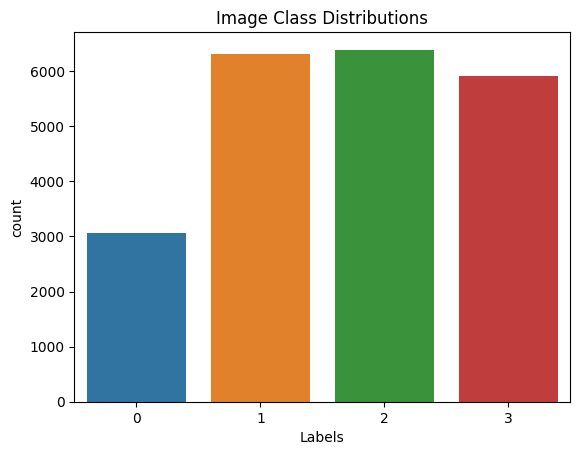

In [ ]:
sns.countplot(data=df, x='Labels')
plt.title('Image Class Distributions')

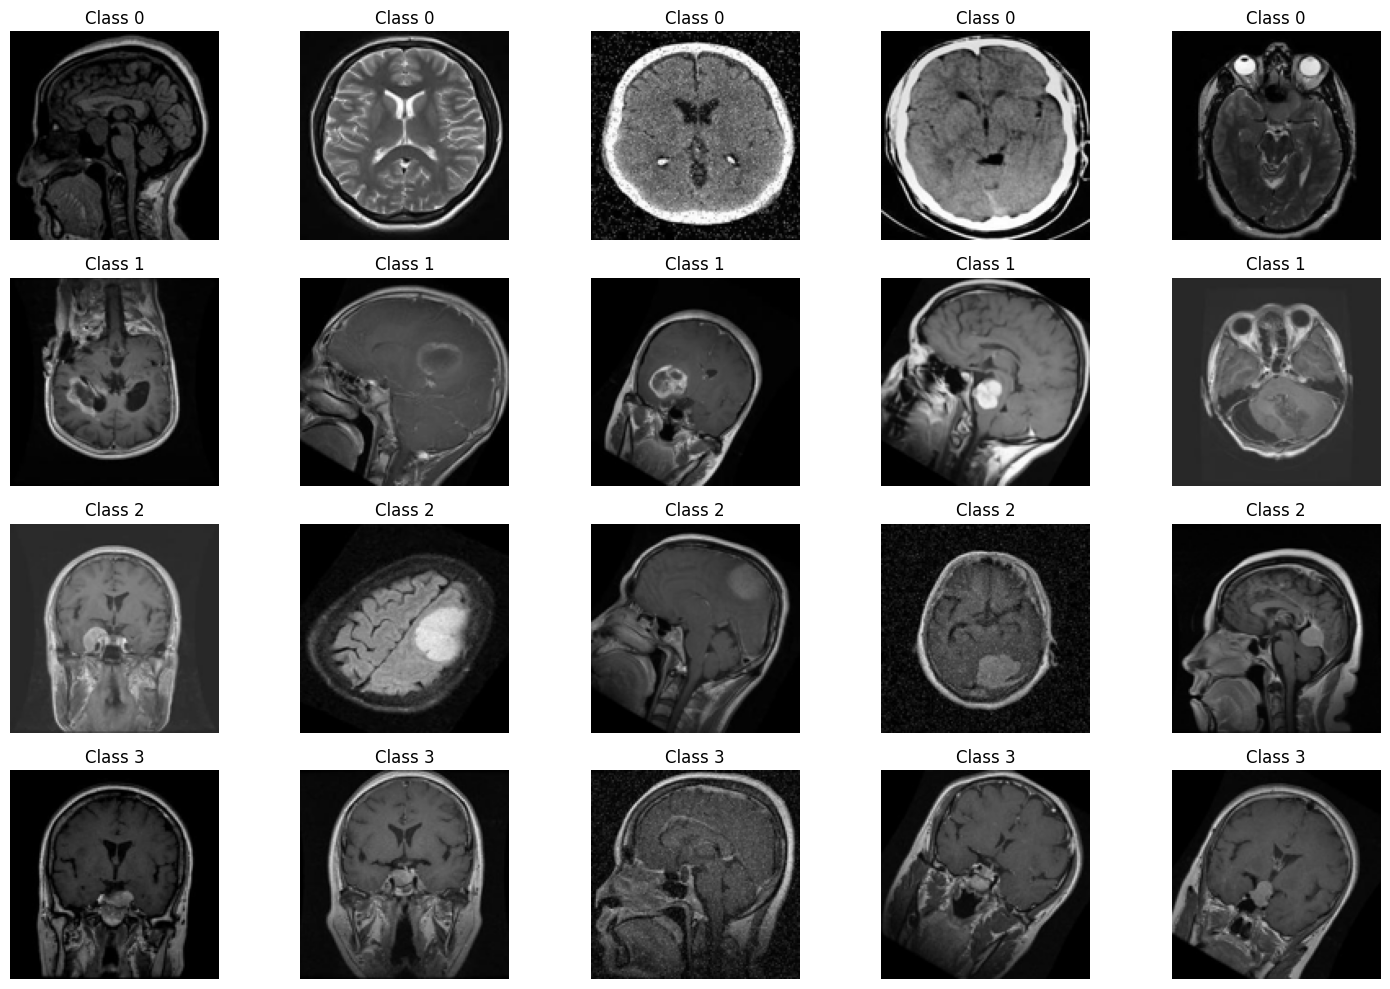

In [ ]:
# Get the unique class labels present in 'y_train'
unique_labels = np.unique(y_train)

# Initialize a dictionary to store the first five representative image indices for each class
representative_indices = {label: [] for label in unique_labels}

# Find the first five representative image indices for each class
for label in unique_labels:
    indices = np.where(y_train == label)[0][:5]  # Get the first five indices of the class
    representative_indices[label] = indices

# Display the first five representative images for each class
num_classes = len(unique_labels)
num_images_per_class = 5

fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(15, 10))
for i, label in enumerate(unique_labels):
    for j, index in enumerate(representative_indices[label]):
        image = X_train[index]
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'Class {label}')
        axs[i, j].axis('off')

plt.tight_layout()  # To ensure proper spacing between the subplots
plt.show()

## Image Size Distribution

In [ ]:
# Extract image heights and widths from the 'image_data' column
image_heights = []
image_widths = []

for image_data in df['image_data']:
    height, width, _ = image_data.shape  # Get the height and width from the image data array
    image_heights.append(height)
    image_widths.append(width)

# Convert the lists to NumPy arrays for further analysis and visualization
image_heights = np.array(image_heights)
image_widths = np.array(image_widths)

# Print the first few elements to verify
print("Image Heights:", image_heights[:5])
print("Image Widths:", image_widths[:5])

Image Heights: [224 224 224 224 224]
Image Widths: [224 224 224 224 224]


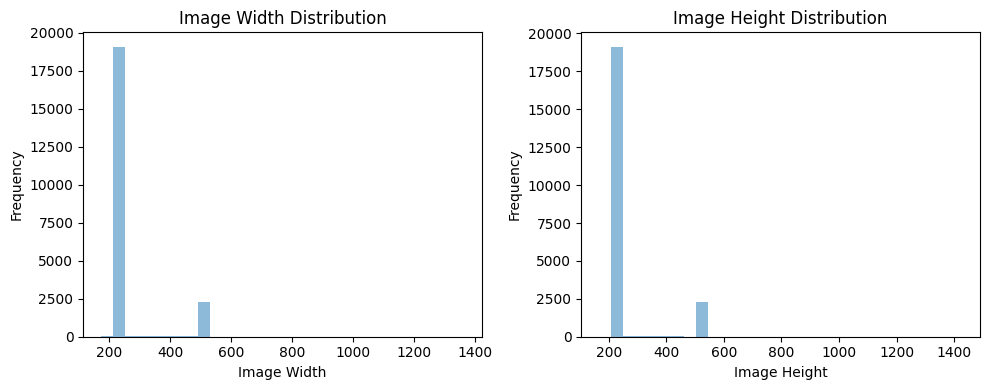

In [ ]:
# Create separate histograms for width and height
plt.figure(figsize=(10, 4))

# Histogram for Width
plt.subplot(1, 2, 1)
plt.hist(image_widths, bins=30, alpha=0.5)
plt.xlabel('Image Width')
plt.ylabel('Frequency')
plt.title('Image Width Distribution')

# Histogram for Height
plt.subplot(1, 2, 2)
plt.hist(image_heights, bins=30, alpha=0.5)
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Image Height Distribution')

plt.tight_layout()  # To ensure proper spacing between the subplots
plt.show()

# Train Test Split

In [ ]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame 'df' with 'image_data' and 'Labels' columns

# Preprocess the image data to a common size (e.g., 128x128)
target_size = (128, 128)
X = np.array([np.array(Image.fromarray(img).resize(target_size)) for img in df['image_data']])
y = np.array(df['Labels'])

# Split the data into train and test sets (80% train, 20% test, for example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17337, 128, 128, 3)
y_train shape: (17337,)
X_test shape: (4335, 128, 128, 3)
y_test shape: (4335,)


# Model Training

## Standard CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Build the CNN model
model = models.Sequential()

# Add convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # Assuming you have 4 classes (0 to 3) in 'y_train'

In [ ]:
# Compile the model with an appropriate loss function, optimizer, and evaluation metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
488/488 [==============================] - 553s 1s/step - loss: 3.4790 - accuracy: 0.6044 - val_loss: 0.7546 - val_accuracy: 0.6926
Epoch 2/10
488/488 [==============================] - 537s 1s/step - loss: 0.5841 - accuracy: 0.7704 - val_loss: 0.5063 - val_accuracy: 0.8212
Epoch 3/10
488/488 [==============================] - 530s 1s/step - loss: 0.4085 - accuracy: 0.8464 - val_loss: 0.4847 - val_accuracy: 0.8374
Epoch 4/10
488/488 [==============================] - 529s 1s/step - loss: 0.3153 - accuracy: 0.8812 - val_loss: 0.4028 - val_accuracy: 0.8552
Epoch 5/10
488/488 [==============================] - 527s 1s/step - loss: 0.2506 - accuracy: 0.9073 - val_loss: 0.3849 - val_accuracy: 0.8766
Epoch 6/10
488/488 [==============================] - 530s 1s/step - loss: 0.1988 - accuracy: 0.9243 - val_loss: 0.3976 - val_accuracy: 0.8824
Epoch 7/10
488/488 [==============================] - 536s 1s/step - loss: 0.1691 - accuracy: 0.9389 - val_loss: 0.4096 - val_accuracy: 0.8795

In [ ]:
# Print the model accuracy after training
accuracy = history.history['accuracy'][-1]
print("Model Accuracy:", accuracy)

In [ ]:
# Plot both training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Dropout & Early Stopping Optimization

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Build the CNN model
model = models.Sequential()

# Add convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout before the output layer
model.add(layers.Dense(4, activation='softmax'))  # Assuming you have 4 classes (0 to 3) in 'y_train'

In [ ]:
# Compile the model with an appropriate loss function, optimizer, and evaluation metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
488/488 [==============================] - 553s 1s/step - loss: 2.2516 - accuracy: 0.4322 - val_loss: 1.0584 - val_accuracy: 0.5634
Epoch 2/10
488/488 [==============================] - 548s 1s/step - loss: 1.0665 - accuracy: 0.5105 - val_loss: 0.8856 - val_accuracy: 0.6390
Epoch 3/10
488/488 [==============================] - 537s 1s/step - loss: 0.9582 - accuracy: 0.5662 - val_loss: 0.7889 - val_accuracy: 0.6897
Epoch 4/10
488/488 [==============================] - 524s 1s/step - loss: 0.8940 - accuracy: 0.5911 - val_loss: 0.7054 - val_accuracy: 0.7197
Epoch 5/10
488/488 [==============================] - 517s 1s/step - loss: 0.8358 - accuracy: 0.6114 - val_loss: 0.6798 - val_accuracy: 0.7226
Epoch 6/10
488/488 [==============================] - 526s 1s/step - loss: 0.7947 - accuracy: 0.6340 - val_loss: 0.6084 - val_accuracy: 0.7428
Epoch 7/10
488/488 [==============================] - 526s 1s/step - loss: 0.7485 - accuracy: 0.6546 - val_loss: 0.6011 - val_accuracy: 0.7549

In [ ]:
# Print the model accuracy after training
accuracy = history.history['accuracy'][-1]
print("Model Accuracy:", accuracy)

Model Accuracy: 0.6967250108718872


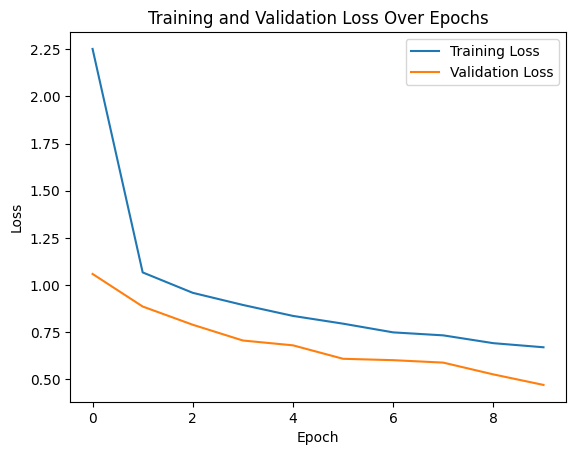

In [ ]:
# Plot both training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

136/136 [==============================] - 37s 275ms/step - loss: 0.4646 - accuracy: 0.8314
Test Accuracy: 0.8313725590705872


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

136/136 [==============================] - 46s 336ms/step


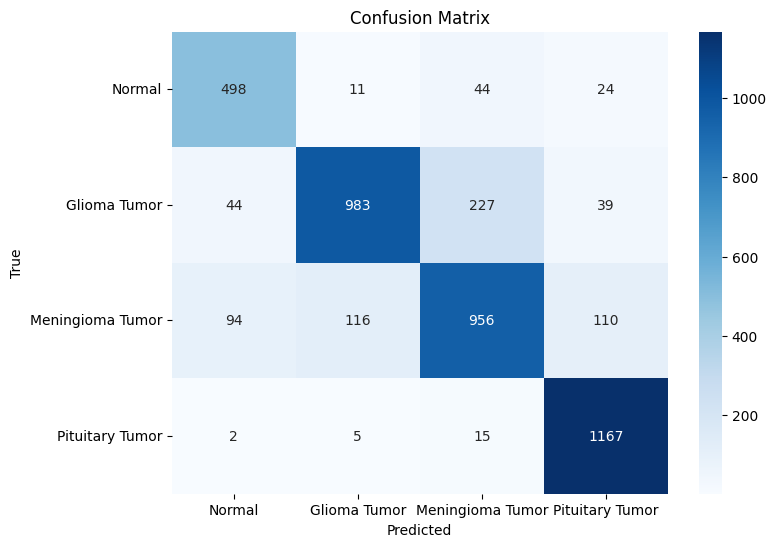

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class labels (assuming you have 4 classes in 'y_test')
class_labels = ['Normal', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate sensitivity (recall) and specificity for each class
sensitivity_per_class = np.diag(cm) / np.sum(cm, axis=1)
specificity_per_class = np.diag(cm) / np.sum(cm, axis=0)

# Print sensitivity and specificity for each class
for class_label, (sensitivity, specificity) in enumerate(zip(sensitivity_per_class, specificity_per_class)):
    print(f"Class {class_label}:")
    print(f"   Sensitivity (Recall): {round(sensitivity,2)}")
    print(f"   Specificity: {round(specificity,2)}")

Class 0:
   Sensitivity (Recall): 0.86
   Specificity: 0.78
Class 1:
   Sensitivity (Recall): 0.76
   Specificity: 0.88
Class 2:
   Sensitivity (Recall): 0.75
   Specificity: 0.77
Class 3:
   Sensitivity (Recall): 0.98
   Specificity: 0.87


# Save Model

In [ ]:
model.save('/content')